# Forex predictions using Machine Learning
# Loading and preparing data

In [1]:
import pandas as pd
from config_bo import EUR_USD
df = pd.read_csv(EUR_USD)
df.tail()

,Gmt time,open,high,low,close,volume
173385,15.04.2023 19:00:00.000,1.09922,1.09922,1.09922,1.09922,0.0
173386,15.04.2023 20:00:00.000,1.09922,1.09922,1.09922,1.09922,0.0
173387,15.04.2023 21:00:00.000,1.09922,1.09922,1.09922,1.09922,0.0
173388,15.04.2023 22:00:00.000,1.09922,1.09922,1.09922,1.09922,0.0
173389,15.04.2023 23:00:00.000,1.09922,1.09922,1.09922,1.09922,0.0


In [2]:
#Check if any zero volumes are available, and remove for the consistency of data 
indexZeros = df[ df['volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["volume"] == 0 )]
df.isna().sum()

Gmt time    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [3]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()  to help with telling you which indicators are available
#help(ta.atr) and tell you what they do  
df['ATR'] = df.ta.atr(length=20) #adr will take into account last 20 bars 
df['RSI'] = df.ta.rsi() # no parameters so will get the default 
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array): # the slope is calculated to determine the trend For instance, a positive slope for a moving average would indicate an upward trend in the data, while a negative slope would suggest a downward trend. 
    y = np.array(array)  
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y) #is a linear regression on the data 
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6 #last six values to guess the slope can be more o less 
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [4]:
df.tail()

,Gmt time,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
173358,14.04.2023 16:00:00.000,1.09789,1.09851,1.09722,1.09775,1.429995e+07,0.001561,24.129711,1.097865,1.103484,1.098782,1.094305,0.000025,0.000142,0.000063,-0.001569,-6.302410
173359,14.04.2023 17:00:00.000,1.09775,1.09901,1.09752,1.09871,9.740260e+06,0.001557,30.347657,1.098265,1.103462,1.098875,1.094365,-0.000009,0.000119,0.000057,-0.001385,-3.424699
173360,14.04.2023 18:00:00.000,1.09871,1.09989,1.09871,1.09988,9.199190e+06,0.001538,37.112234,1.099300,1.103477,1.098970,1.094435,-0.000025,0.000103,0.000056,-0.000791,-0.598708
173361,14.04.2023 19:00:00.000,1.09987,1.09992,1.09921,1.09964,4.669030e+06,0.001497,36.332740,1.099565,1.103498,1.099085,1.094500,-0.000020,0.000097,0.000059,-0.000230,1.982091
173362,14.04.2023 20:00:00.000,1.09964,1.09977,1.09920,1.09922,3.125180e+06,0.001450,34.949309,1.099485,1.103504,1.099185,1.094563,-0.000004,0.000099,0.000063,0.000212,2.748812


# Target categories

In [5]:
#Target flexible way
pipdiff = 500*1e-5 #for TP   # to guess the price # This is the difference in price that you’re looking for in your target. It’s set to 500*1e-5, which is equivalent to 0.005. In the context of forex trading, a pip is a unit of measure for currency movement and is the fourth decimal place in most currency pairs.
SLTPRatio = 2 #pipdiff/Ratio gives SL     #This is the Stop Loss to Take Profit ratio. It’s set to 2, which means that the stop loss is half the size of the take profit target. This is a common risk management strategy in trading.

def mytarget(barsupfront, df1): #barsupfront  is the number of names  # This function is used to determine the trend of the market. It checks if the price has moved up or down by a certain amount (defined by pipdiff and SLTPRatio) in the next few bars (defined by barsupfront). If it has, it categorizes the trend as up (2) or down (1). If the price hasn’t moved significantly, it categorizes the trend as unclear (0).
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [6]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.head()

,Gmt time,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
21,04.05.2003 21:00:00.000,1.12284,1.12338,1.12242,1.12305,2.905910e+07,NaN,NaN,1.122900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
22,04.05.2003 22:00:00.000,1.12274,1.12302,1.12226,1.12241,2.609180e+07,NaN,NaN,1.122640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
23,04.05.2003 23:00:00.000,1.12235,1.12235,1.12160,1.12169,2.924090e+07,NaN,NaN,1.121975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
24,05.05.2003 00:00:00.000,1.12161,1.12314,1.12154,1.12258,2.991480e+07,NaN,NaN,1.122340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
25,05.05.2003 01:00:00.000,1.12232,1.12262,1.12099,1.12140,2.837070e+07,NaN,NaN,1.121805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


# Quick analysis example

/var/folders/k5/h1ckqhvs6kb6sb1p9b_90n1w0000gn/T/ipykernel_56717/2271519335.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


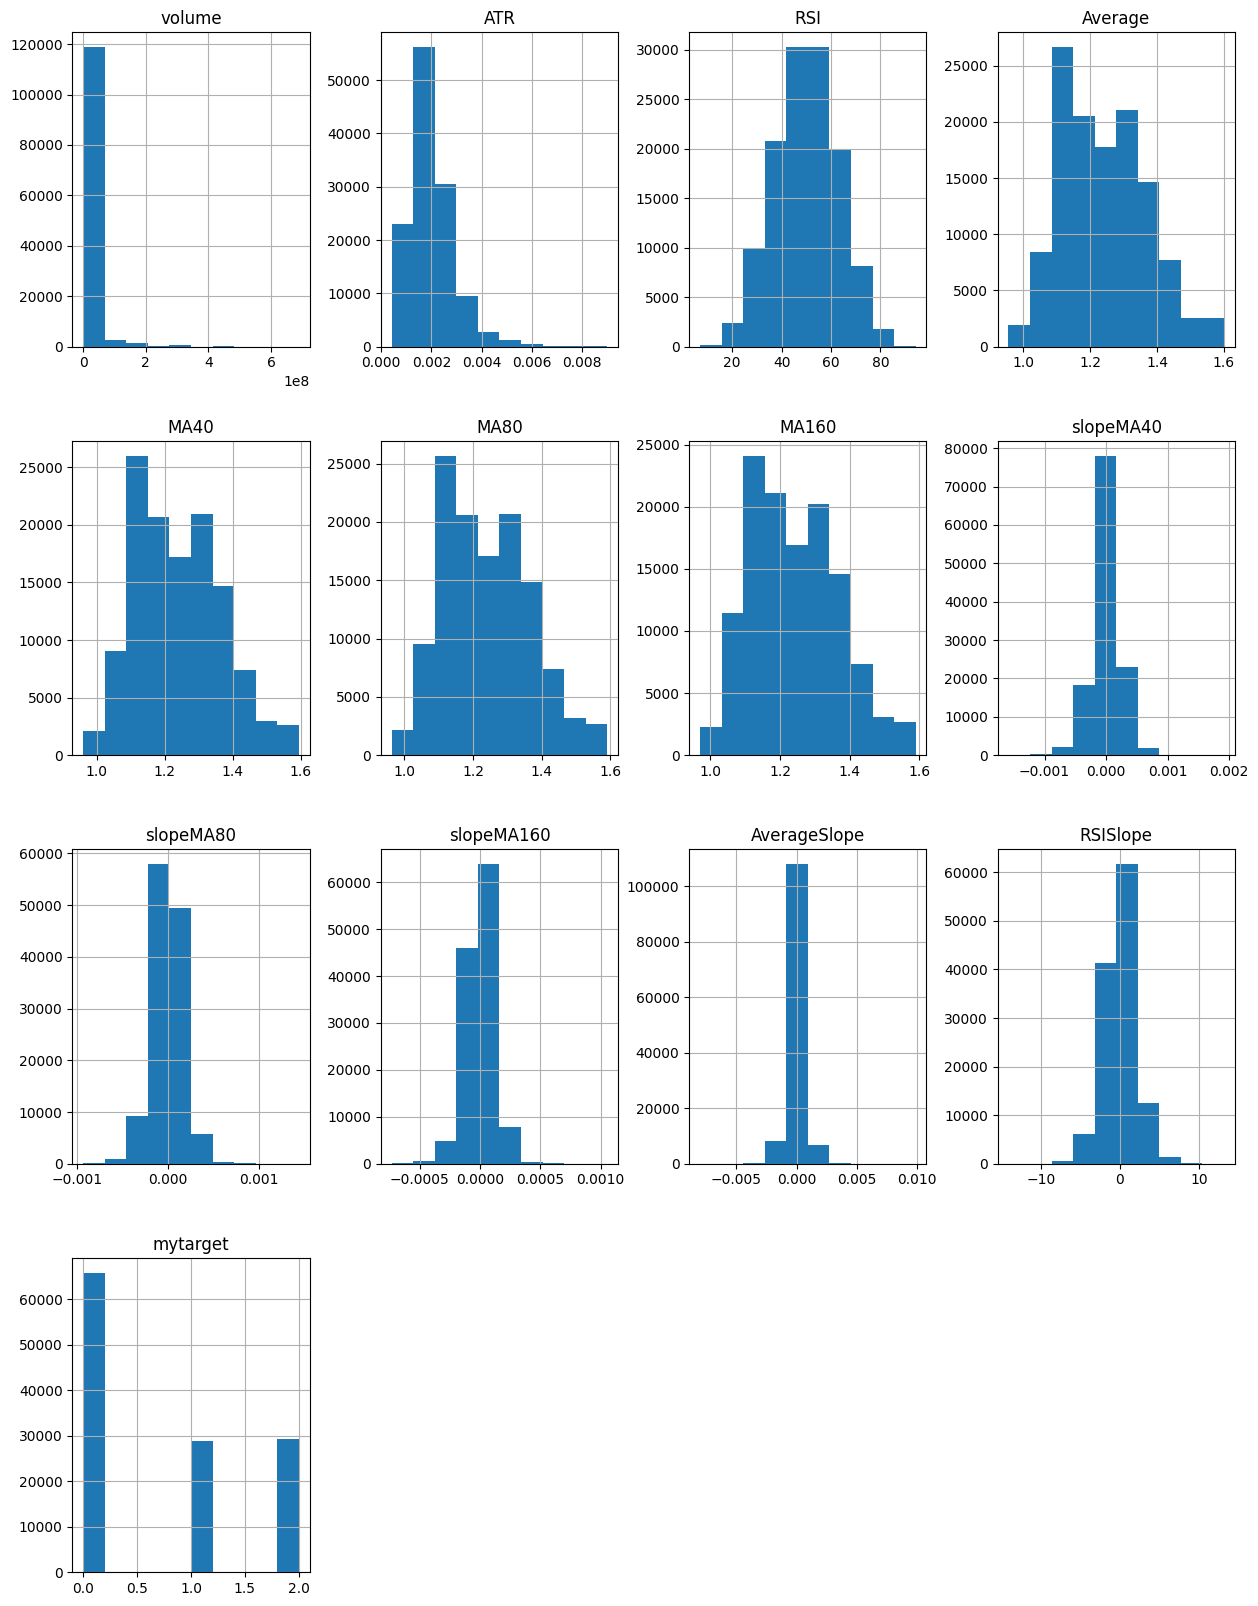

In [7]:
import matplotlib.pyplot as plt #Histograms provide a visual representation of data distribution. Each bar in a histogram represents the tabulated frequency at each interval/bin. The x-axis represents the data to be measured, while the y-axis represents the frequency count. By looking at the shape of the bars, you can get a general idea about the range of values, the central tendency, and the spread of the data.
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

## Can we use the RSI alone as a trend indicator?

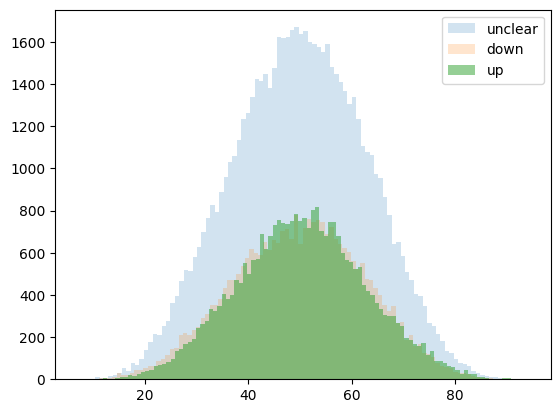

In [11]:
from matplotlib import pyplot # you can also combine 2-3 technical indicators 

# The code you provided is creating histograms of the Relative Strength Index (RSI) values for three different trend categories: up, down, and unclear. The RSI is a momentum oscillator that measures the speed and change of price movements. It is often used as a trend indicator in technical analysis of financial markets.
# Here’s what you should look for in the histograms to determine if RSI alone is sufficient as a trend indicator:

#     Separation of Distributions: If the distributions of RSI values for the up, down, and unclear trends are well separated (i.e., they do not overlap significantly), it suggests that the RSI values are distinct for each trend category. This would indicate that RSI alone could be a good indicator of the trend.

#     Overlap of Distributions: If the distributions overlap significantly, it suggests that the RSI values are not distinct for each trend category. In this case, RSI alone might not be sufficient to reliably indicate the trend.

#     Shape of Distributions: The shape of the distributions can also provide insights. For example, if the distribution for the up trend is skewed towards higher RSI values and the distribution for the down trend is skewed towards lower RSI values, this would suggest that RSI is a good indicator of the trend.

df_up=df.RSI[ df['mytarget'] == 2 ] #uprtrend 2
df_down=df.RSI[ df['mytarget'] == 1 ] #downtrend 1
df_unclear=df.RSI[ df['mytarget'] == 0 ] # unclear trend 0
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear') #alpha is transparency #bin  the number of equal-width bins in the range of the data. The bins are the divisions in the histogram that represent the width of the intervals. For example, if bins=100, it means the data will be divided into 100 equal-width bins when creating the histogram.
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

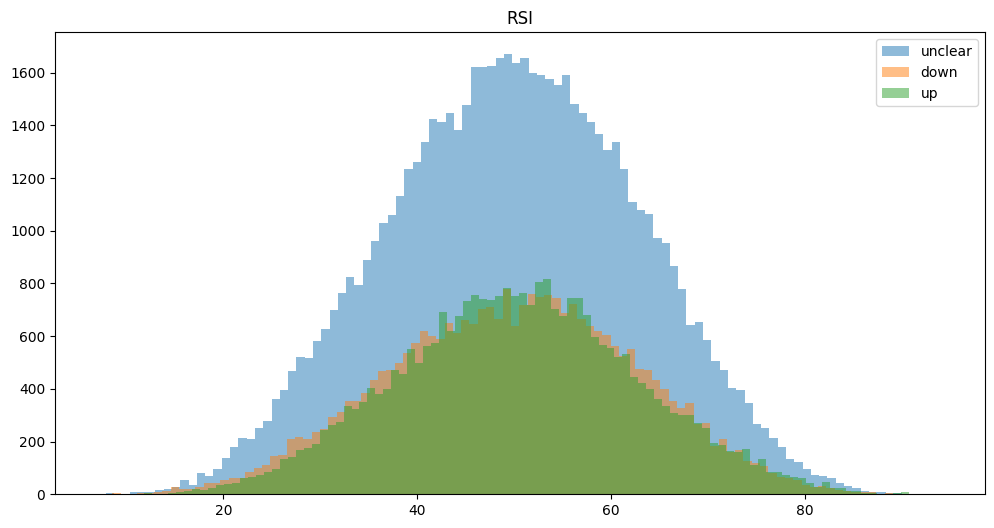

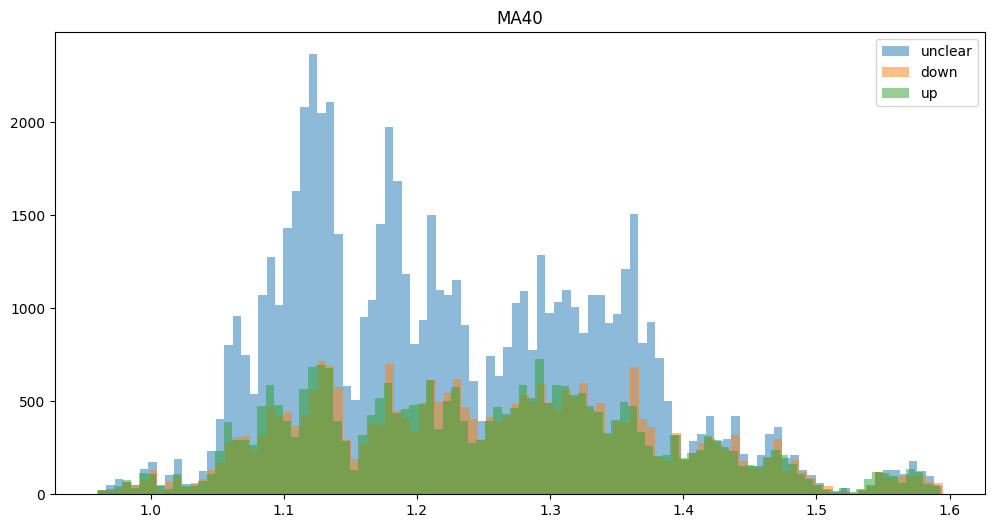

In [12]:
#i added this
# from matplotlib import pyplot

# # Create subsets of the data for each trend category
# df_up = df[['RSI', 'MA40']][df['mytarget'] == 2]  # uptrend
# df_down = df[['RSI', 'MA40']][df['mytarget'] == 1]  # downtrend
# df_unclear = df[['RSI', 'MA40']][df['mytarget'] == 0]  # unclear trend

# # Create histograms for RSI
# pyplot.figure(figsize=(12, 6))
# pyplot.hist(df_unclear['RSI'], bins=100, alpha=0.5, label='unclear')
# pyplot.hist(df_down['RSI'], bins=100, alpha=0.5, label='down')
# pyplot.hist(df_up['RSI'], bins=100, alpha=0.5, label='up')
# pyplot.title('RSI')
# pyplot.legend(loc='upper right')
# pyplot.show()

# # Create histograms for MA40
# pyplot.figure(figsize=(12, 6))
# pyplot.hist(df_unclear['MA40'], bins=100, alpha=0.5, label='unclear')
# pyplot.hist(df_down['MA40'], bins=100, alpha=0.5, label='down')
# pyplot.hist(df_up['MA40'], bins=100, alpha=0.5, label='up')
# pyplot.title('MA40')
# pyplot.legend(loc='upper right')
# pyplot.show()

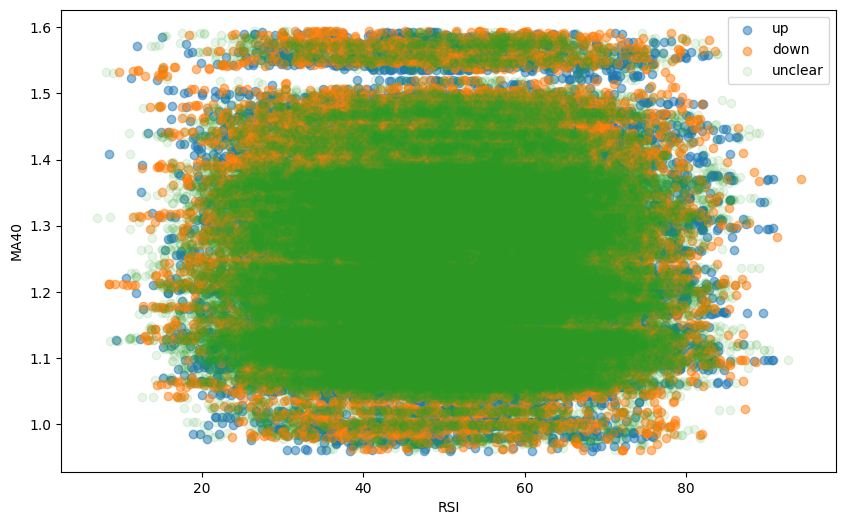

In [15]:
# i added this 
# import matplotlib.pyplot as plt

# # Create scatter plots for each trend category
# plt.figure(figsize=(10, 6))
# plt.scatter(df_up['RSI'], df_up['MA40'], alpha=0.5, label='up')
# plt.scatter(df_down['RSI'], df_down['MA40'], alpha=0.5, label='down')
# plt.scatter(df_unclear['RSI'], df_unclear['MA40'], alpha=0.1, label='unclear')

# plt.xlabel('RSI')
# plt.ylabel('MA40')
# plt.legend(loc='upper right')
# plt.show()

# Machine learning for trend prediction

## 1 - the perfect model with precise prediction

## 2 - less perfect model still with > 40% precision

## 3 - much less perfect model with precision >35% taking into account our strategy, and our TP/SL ratio 

### can't let an automated program run your trades
### it can be your version of a smart indicator (based on machine learning)

## 4 - Our target has categorical values so we need a classificator, KNN?

## Splitting features and target

In [16]:
df_model=df_model.dropna() # cleaning the rows with no numbers data 

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

             ATR        RSI   Average      MA40      MA80     MA160   
233     0.003103  45.751289  1.150680  1.154190  1.151510  1.142057  \
234     0.003079  49.520906  1.151320  1.154080  1.151723  1.142247   
235     0.003070  48.112068  1.152345  1.153940  1.151919  1.142434   
236     0.002984  47.359699  1.151220  1.153788  1.152020  1.142621   
237     0.002958  50.681912  1.152155  1.153690  1.152086  1.142814   
...          ...        ...       ...       ...       ...       ...   
173340  0.001252  65.701812  1.104725  1.100058  1.094849  1.092896   
173341  0.001208  67.068165  1.104975  1.100370  1.095115  1.092959   
173342  0.001198  68.094762  1.105385  1.100697  1.095373  1.093024   
173343  0.001192  71.401712  1.105825  1.101036  1.095633  1.093094   
173344  0.001192  73.500860  1.106910  1.101401  1.095897  1.093172   

        slopeMA40  slopeMA80  slopeMA160  AverageSlope  RSISlope  
233     -0.000073   0.000232    0.000183     -0.000445 -1.443562  
234     -0.00

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fitting the KNN model

In [19]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Quick evaluation of our fitting

In [20]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 53.31%
Accuracy test: 52.44%
mytarget
0.0    53.115422
2.0    23.613324
1.0    23.271254
Name: count, dtype: float64
Accuracy Gambler: 33.50%


## More powerful model XGBoost

In [22]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 67.7843%
****Test Results****
Accuracy: 59.5585%


## !!Data sampling shouldn't be random

In [23]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 68.6112%
****Test Results****
Accuracy: 60.1245%


## Which features are most important for our model?

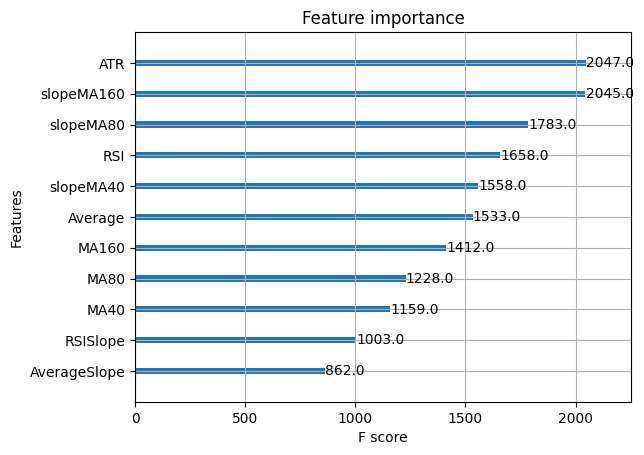

In [24]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

# Automated orders using python and Machine Learning
## Previous videos
### 1 - Install Anaconda, Jupyter NB, Pandas_TA (Technical Analysis)
### 2 - Download price data from online resources, and add our technical indicators to our exchange price dataframe
### 3 - Fit a Machine learning model and predict future price trends using KNN and XGBOOST classifiers
### 4 - Save and Load a ML model,
### - according to the model's advice
### - passing orders (sell/buy) automatically
### - send an email notification about newly applied trading operations

## Load Machine Learning Model from Disk and Test it

In [19]:
import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

## Live Automated Orders with email notification

In [32]:
from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails


import smtplib
gmail_user = 'email@gmail.com'
gmail_password = 'email password here'
sent_from = gmail_user
to = ['email@gmail.com']
subject = 'info CHF'


In [30]:
ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()
    
    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average', 
    #'MA40', 'MA80', 'MA160', 'slopeMA40', 
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]
    
    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)
  
    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with 
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________
    
    
    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)
    
    pipdiff = 500*1e-5 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL
    
    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)
    
    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

## Executing orders automatically every 4 Hours

In [33]:
#some_job()

###################################################################
## Interval time job ##############################################
scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 15*60})
scheduler.add_job(some_job, 'cron', day_of_week='mon-fri', hour='*/4', minute=5, jitter=120, timezone='America/New_York')
#scheduler.add_job(some_job, 'interval', hours=4)
scheduler.start()

V20Error: {"errorMessage":"Insufficient authorization to perform request."}